# Data Processing: answers

In [1]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import numpy as np
import random
import pathlib
import os
import shutil

## EXERCISE 1: CIFAR10 

### A. Load CIFAR10 dataset (train and test sets). Apply transformations to convert the images to tensors and normalize them using mean = [0.5, 0.5, 0.5] and std = [0.5, 0.5, 0.5]. (Use **transform.Compose**).

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

# Load CIFAR10 train and test datasets
train_data = datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


### B. Create the dataloaders using batchsize = 4.

In [3]:
train_dataloader = DataLoader(train_data, batch_size = 4, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 4, shuffle = False)

### C. Indicate the image shape [color_channels, height, width]. 

In [4]:
# See first training sample
image, label = train_data[0]

# Check the shape of the image.
print(f"Image shape: {image.shape} -> [color_channels, height, width]")

Image shape: torch.Size([3, 32, 32]) -> [color_channels, height, width]


### D. Which classes are included in the dataset?

In [5]:
classes = train_data.classes
print(f"There are {len(classes)} categories in the dataset:\n {classes}")

There are 10 categories in the dataset:
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### E. Calculate the total number of samples in the CIFAR10 train and test datasets

In [6]:
train_samples = len(train_data)
test_samples = len(test_data)
print("Number of samples in train dataset:", train_samples)
print("Number of samples in test dataset:", test_samples)

Number of samples in train dataset: 50000
Number of samples in test dataset: 10000


### F. Displays 5 random images with their corresponding label. Optional:Use (seed=42) for reproducibility

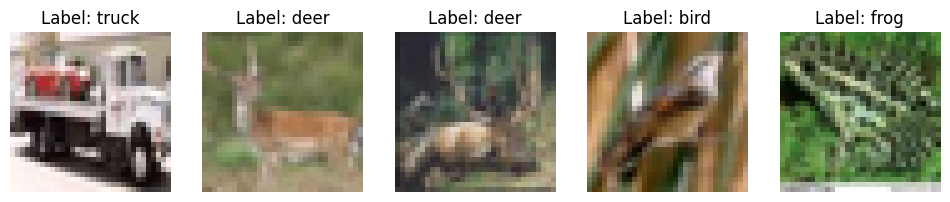

In [7]:
# Set random seed for reproducibility (optional)
random.seed(42)

# Display 5 random images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i in range(5):
    # Get a random sample
    index = random.randint(0, len(train_data))
    image, label = train_data[index]
    
    # Convert image tensor to numpy array and unnormalize it
    image = image.numpy().transpose(1, 2, 0)
    image = image * 0.5 + 0.5  # Unnormalize
    
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {classes[label]}")
    axes[i].axis('off')

plt.show()

## EXERCISE 2: WEATHER DATASET 

This code demonstrates one possible solution to address the raised issues. However, it's important to note that there might be alternative approaches that could also be utilized.

### A. Define the transformations for the training, testing, and validation datasets.

In [8]:
# Define the transformation steps using transforms.Compose()
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomEqualize(),
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation((-10, 10)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

### B. Create the datasets (you can use the ImageFolder class) and dataloaders. Show relevant information such as the sizes of the different datasets or the number of classes.

In [9]:
# Define the data_dir
data_dir = '../datasets/Weather_Dataset_Split'
splits = ['train', 'val', 'test']

# Create the datasets using ImageFolder class
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 8, shuffle = True, num_workers = 1) for x in splits}

# Calculate the sizes of the different datasets and obtain the class names
dataset_sizes = {x: len(image_datasets[x]) for x in splits}
class_names = image_datasets['train'].classes

# Print the information
print("Dataset Sizes:", dataset_sizes)
print("Class Names:", class_names)

Dataset Sizes: {'train': 809, 'val': 146, 'test': 170}
Class Names: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


### Aditional information: Represent the distribution of data
Representing the distribution of data is important to determine if we have an imbalanced dataset. Fortunately, in our case, we have a consistent dataset where each category contains approximately an equal number of images

In [13]:
# Calculate the number of images in each category for each dataset
category_counts = {x: {class_names[i]: 0 for i in range(len(class_names))} for x in splits}

for x in splits:
    for _, label in image_datasets[x]:
        category_counts[x][class_names[label]] += 1

# Print the category counts
for x in splits:
    print("Category counts for", x, "dataset:")
    for category, count in category_counts[x].items():
        print(category, ":", count)
    print()

Category counts for train dataset:
Cloudy : 216
Rain : 154
Shine : 182
Sunrise : 257

Category counts for val dataset:
Cloudy : 39
Rain : 28
Shine : 33
Sunrise : 46

Category counts for test dataset:
Cloudy : 45
Rain : 33
Shine : 38
Sunrise : 54



Let's show these results in a graph:

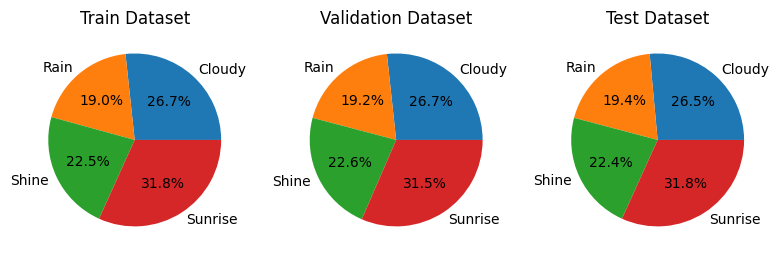

In [14]:
# Create lists for labels and counts
labels = list(class_names)
train_counts = [category_counts['train'][category] for category in labels]
val_counts = [category_counts['val'][category] for category in labels]
test_counts = [category_counts['test'][category] for category in labels]

# Set the figure size
plt.figure(figsize=(8, 8))

# Create the subplots for train, val, and test datasets
plt.subplot(1, 3, 1)
plt.pie(train_counts, labels = labels, autopct = '%1.1f%%')
plt.title('Train Dataset')

plt.subplot(1, 3, 2)
plt.pie(val_counts, labels = labels, autopct = '%1.1f%%')
plt.title('Validation Dataset')

plt.subplot(1, 3, 3)
plt.pie(test_counts, labels = labels, autopct = '%1.1f%%')
plt.title('Test Dataset')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

### C. Visualize a few images with their corresponding labels

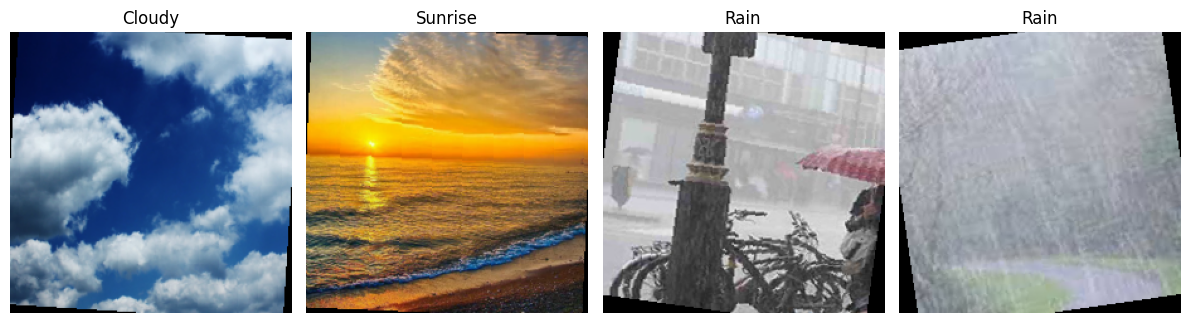

In [36]:
# Define the mean and standard deviation of ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Get a batch of images from the training dataloader
train_batch = next(iter(dataloaders['train']))
train_images, train_labels = train_batch

# Unnormalize the images
unnormalize = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1.0/std[0], 1.0/std[1], 1.0/std[2]))
train_images = unnormalize(train_images)

# Plot some of the images from the training dataset
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i in range(4):
    img = train_images[i]
    img = img.permute(1, 2, 0)  # Reshape tensor from (C, H, W) to (H, W, C)
    class_index = train_labels[i].item()
    class_name = class_names[class_index]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(class_name)

plt.tight_layout()
plt.show()